# Code to Solve the Image Deblurring Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{S} \left( \boldsymbol{b} \circledast \boldsymbol{x} + \boldsymbol{\varepsilon} \right) = \boldsymbol{S} \left( \mathcal{C} (\boldsymbol{b})\boldsymbol{x} + \boldsymbol{\varepsilon} \right), \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{x} \in \mathbb{R}^{n}$: (vectorized) unknown image to recover 
- $\boldsymbol{b} \in \mathbb{R}^{n}$: (vectorized) blurring kernel
- $\mathcal{C}(\boldsymbol{b})$ : circulant matrix of $\boldsymbol{b}$
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{R}^{n}$: observed measurements
- $ \circledast : \mathbb{R}^{n} \times \mathbb{R}^{n} \mapsto \mathbb{R}^{n}$: denotes cicular convolution (https://en.wikipedia.org/wiki/Convolution)
- $ \boldsymbol{S} \in \mathbb{R}^{m} \times \mathbb{R}^{n}$: subsampling matrix

## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{x}}) = \frac{1}{2m} \| \boldsymbol{y} - \boldsymbol{S} \mathcal{C} (\boldsymbol{b})\boldsymbol{x} \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{x}) := \frac{1}{m} \sum_i^m \ell_{i}(\boldsymbol{x}) = \frac{1}{m}\sum_i^m \frac{1}{2}(y_i - \mathcal{C}_i(\boldsymbol{b}) \boldsymbol{x})^2$

- $\mathcal{C}_i(\boldsymbol{b})$ denotes the $i^{\text{th}}$ row of the circulant matrix of $\boldsymbol{b}$

### Full gradient:

$\nabla \ell ({\boldsymbol{x}}) = \frac{1}{m} \mathcal{C} (\boldsymbol{b})^\top \boldsymbol{S}^\top  ( \boldsymbol{S} \mathcal{C} (\boldsymbol{b}) \boldsymbol{x} - \boldsymbol{y} ) $

### Stochastic gradient:

$\nabla \ell_{i}({\boldsymbol{x}}) = \boldsymbol{S}^\top_i \mathcal{C} (\boldsymbol{b})^\top_i (\boldsymbol{x}^\top \mathcal{C}_i(\boldsymbol{b}) - y_i ) $



In [2]:
%matplotlib inline 

from imports import *
import pylops

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# No Subsampling --> Perfect Recovery?

(512, 512)
c:\Users\14807\Documents\GitHub\pnp-svrg\.venv\lib\site-packages\skimage\metrics\simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


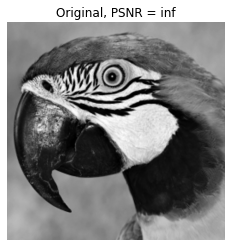

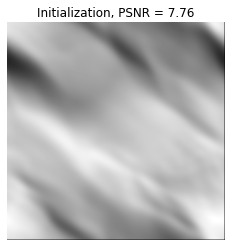

In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

height = 512
width = 512

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=.0,  scale_percent=100, lr_decay=1.0)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 511.5, 511.5, -0.5)

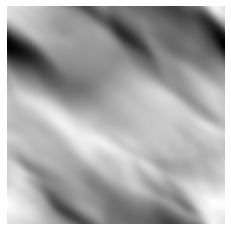

In [15]:
measurements = problem.y
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [29]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.005, patch_size=5, patch_distance=6, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_gd(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=1, tt=100, verbose=True)

0 Before denoising:  11.76295090723003
0 After denoising:  11.76304743863048
1 Before denoising:  13.2106951913924
1 After denoising:  13.210859177229397
2 Before denoising:  13.83884574833581
2 After denoising:  13.839166853446955
3 Before denoising:  14.167822342314958
3 After denoising:  14.168277546324921
4 Before denoising:  14.381937668169549
4 After denoising:  14.382397711643035
5 Before denoising:  14.547631601020957
5 After denoising:  14.548067612723855
6 Before denoising:  14.68909440432282
6 After denoising:  14.689506848613071
7 Before denoising:  14.815251390447784
7 After denoising:  14.815674984989478
8 Before denoising:  14.929944674538083
8 After denoising:  14.930404715233173
9 Before denoising:  15.035045787785341
9 After denoising:  15.035555332395603
10 Before denoising:  15.131754029015287
10 After denoising:  15.132302504747999
11 Before denoising:  15.220912188601645
11 After denoising:  15.221483631534412
12 Before denoising:  15.303220057357457
12 After deno

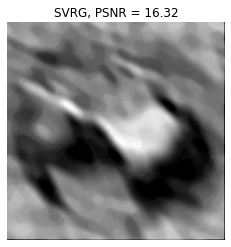

In [17]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=512, W=512)

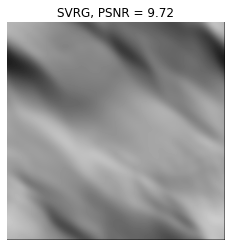

In [31]:
Xhat = problem.Bop.div(problem.y.flatten())
psnr_display(img_path='./data/Set12/07.png', output=Xhat.reshape(problem.dim_old), title="SVRG", H=512, W=512)

# Subsample rate of 2

In [ ]:
height = 512
width = 512
scaling = 50

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=10/256, blur_size_x=9, blur_size_y=9,  scale_percent=scaling, lr_decay=1)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

In [ ]:
measurements = problem.y
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [ ]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.012, patch_size=5, patch_distance=9, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=.1, tt=30, T2=1, 
                                                   mini_batch_size=problem.num_meas//1, verbose=True)

In [ ]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=512, W=512)

# Subsample rate of 4

In [ ]:
height = 128
width = 128
subsample_rate = 4

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=0.1, subsampling=subsample_rate)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

In [ ]:
measurements = problem.y.reshape(height//subsample_rate,width//subsample_rate)
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [ ]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.01, patch_size=5, patch_distance=12, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=.001, tt=100, T2=10, 
                                                   mini_batch_size=problem.num_meas//10, verbose=True)

In [ ]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=128, W=128)